In [25]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
import datetime

# for feature selection
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [49]:
infile = "calval_regression_data_times.p"
outfile = 'model_feature_selection_with_times.xlsx'
#remove = 'thedonald'
remove = False
SCORING_METHOD = 'roc_auc'
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'post_activity_count',
    'comment_activity_count', 'hour', 'time_in_secs', 'num_dayofweek', 
    ]
Y_COL = 'success'



In [18]:
def logit_forward_sequential_selection(X, y, test=True, name=''):
    if test:
        X_train = X['calibration']
        X_test = X['validation']
        y_train = y['calibration']
        y_test = y['validation']
    else:
        X_train = X
        y_train = y
    
    max_k = len(X_train.columns)
    k=(1, max_k)

    sfs = SequentialFeatureSelector(
        linear_model.LogisticRegression(),
        k_features = k,
        forward=True,
        scoring=SCORING_METHOD,
        cv=None,
        )
    
    selected_features = sfs.fit(X_train, y_train)
    print(f'selected features: {selected_features.k_feature_names_}')
    metric_df = pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index')
    display(metric_df)

    if test:
        # Generate the new subsets based on the selected features
        # Note that the transform call is equivalent to
        # X_train[:, sfs1.k_feature_idx_]
        X_train_sfs = selected_features.transform(X_train)
        X_test_sfs = selected_features.transform(X_test)

        # Fit the estimator using the new feature subset
        # and make a prediction on the test data
        logit = linear_model.LogisticRegression()
        logit.fit(X_train_sfs, y_train)
        y_pred = logit.predict(X_test_sfs)

        # Compute the accuracy of the prediction
        acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
        print('Test set accuracy: %.2f %%' % (acc * 100))

        # Compute the AUC of the prediction
        auc = metrics.roc_auc_score(y_test,  y_pred)
        print('Test set ROC AUC: %.2f' % (auc))
    

    fig1 = plot_sfs(selected_features.get_metric_dict(), kind='std_dev')
    plt.title(f'{name} Sequential Forward Selection (w. StdDev)')
    plt.ylabel('Performance - roc auc')
    plt.show()
    results = {
        'metric_df': metric_df,
        'selected_features': selected_features.k_feature_names_,
        'test_set_accuracy': acc,
        'test_set_auc': auc
    }
    return results

In [46]:
def float_seconds(time_row):
    hours = time_row.hour
    minutes = time_row.minute
    seconds = time_row.second
    return hours*60*60 + minutes*60 + seconds

def get_dayofweek(timestamp):
    return timestamp.dayofweek

In [9]:
regression_thread_data = pickle.load(open(infile, 'rb'))
if remove:
    regression_thread_data.pop(remove)

In [40]:
for subr in regression_thread_data:
    for key in regression_thread_data[subr]:
        regression_thread_data[subr][key]['time_in_secs'] = regression_thread_data[subr][key].time.apply(float_seconds)

In [48]:
for subr in regression_thread_data:
    for key in regression_thread_data[subr]:
        regression_thread_data[subr][key]['num_dayofweek'] = regression_thread_data[subr][key].timestamp.apply(get_dayofweek)

In [50]:
pickle.dump(regression_thread_data, open(infile, 'wb'))


### books ###
selected features: ('post_activity_count', 'comment_activity_count', 'num_dayofweek')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.766268109407875],0.766268,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7796964232040878],0.779696,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(2, 3, 6)",[0.7816629596232842],0.781663,"(post_activity_count, comment_activity_count, ...",NaN,0.0,NaN
4,"(2, 3, 4, 6)",[0.781494840196373],0.781495,"(post_activity_count, comment_activity_count, ...",NaN,0.0,NaN
5,"(1, 2, 3, 4, 6)",[0.779164011622082],0.779164,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 4, 6)",[0.7634886283939485],0.763489,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.7076555455365194],0.707656,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 73.55 %
Test set ROC AUC: 0.57


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


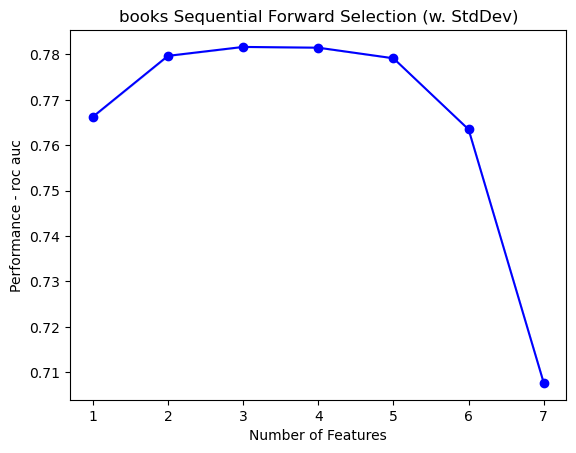


### conspiracy ###
selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.7774060348014974],0.777406,"(comment_activity_count,)",NaN,0.0,NaN
2,"(3, 6)",[0.7443353327055506],0.744335,"(comment_activity_count, num_dayofweek)",NaN,0.0,NaN
3,"(2, 3, 6)",[0.7284184667275193],0.728418,"(post_activity_count, comment_activity_count, ...",NaN,0.0,NaN
4,"(0, 2, 3, 6)",[0.7216545178205543],0.721655,"(sentiment_sign, post_activity_count, comment_...",NaN,0.0,NaN
5,"(0, 2, 3, 4, 6)",[0.7158602861032799],0.715860,"(sentiment_sign, post_activity_count, comment_...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 4, 6)",[0.7094698052910908],0.709470,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6581794447397205],0.658179,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 85.73 %
Test set ROC AUC: 0.50


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


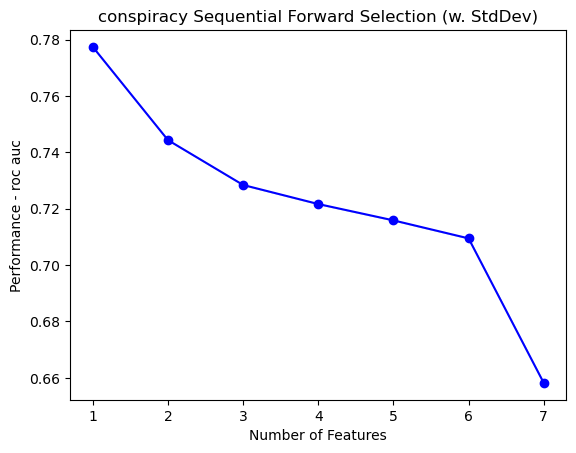


### crypto ###
selected features: ('comment_activity_count',)


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.8185895728905598],0.818590,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7718789719835302],0.771879,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.758764116392171],0.758764,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.7556305197517603],0.755631,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
5,"(0, 1, 2, 3, 4)",[0.752468671679198],0.752469,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 4, 6)",[0.7520023458944982],0.752002,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.7082151621613557],0.708215,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Test set accuracy: 63.92 %
Test set ROC AUC: 0.58


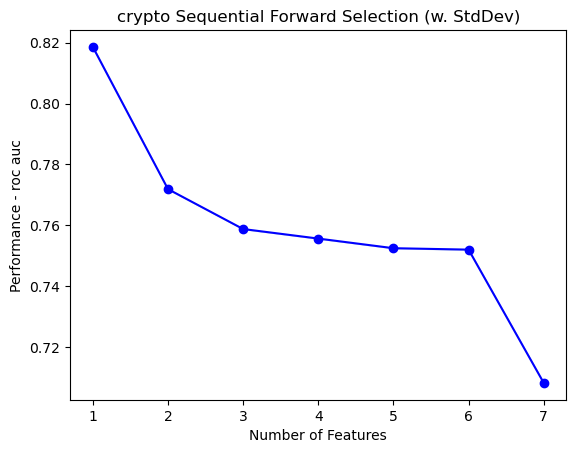


### politics ###
selected features: ('post_activity_count', 'comment_activity_count')


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)",[0.7082103674819289],0.708210,"(comment_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.7146160205472986],0.714616,"(post_activity_count, comment_activity_count)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.6956303789405782],0.695630,"(sentiment_magnitude, post_activity_count, com...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.6892019986014861],0.689202,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
5,"(0, 1, 2, 3, 6)",[0.6769229157865595],0.676923,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 5, 6)",[0.6754002291041796],0.675400,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 4, 5, 6)",[0.6754003375228974],0.675400,"(sentiment_sign, sentiment_magnitude, post_act...",NaN,0.0,NaN


Test set accuracy: 67.31 %
Test set ROC AUC: 0.50


/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cara/anaconda3/envs/redditenv/lib/python3.10/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


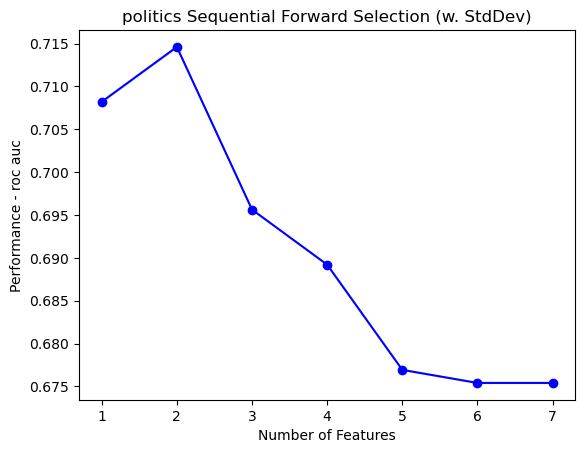

In [51]:
FSS_metrics = {}
for key in regression_thread_data:
    print(f'\n### {key} ###')
    X = {}
    y = {}
    for calval in regression_thread_data[key]:
        X[calval] = regression_thread_data[key][calval][X_COLS]
        y[calval] = regression_thread_data[key][calval][Y_COL]
    FSS_metrics[key] = logit_forward_sequential_selection(X, y, name=key)

In [52]:
FSS_metrics

{'books': {'metric_df':              feature_idx             cv_scores  avg_score  \
  1                   (3,)   [0.766268109407875]   0.766268   
  2                 (2, 3)  [0.7796964232040878]   0.779696   
  3              (2, 3, 6)  [0.7816629596232842]   0.781663   
  4           (2, 3, 4, 6)   [0.781494840196373]   0.781495   
  5        (1, 2, 3, 4, 6)   [0.779164011622082]   0.779164   
  6     (0, 1, 2, 3, 4, 6)  [0.7634886283939485]   0.763489   
  7  (0, 1, 2, 3, 4, 5, 6)  [0.7076555455365194]   0.707656   
  
                                         feature_names  ci_bound  std_dev  \
  1                          (comment_activity_count,)       NaN      0.0   
  2      (post_activity_count, comment_activity_count)       NaN      0.0   
  3  (post_activity_count, comment_activity_count, ...       NaN      0.0   
  4  (post_activity_count, comment_activity_count, ...       NaN      0.0   
  5  (sentiment_magnitude, post_activity_count, com...       NaN      0.0   
  6  (sen

In [53]:
i = 0
other_feats_dict = {}
for key in FSS_metrics:
    df = FSS_metrics[key]['metric_df'][['feature_idx', 'cv_scores', 'avg_score', 'feature_names']].reset_index().rename(columns={'index': 'number_features'})
    df.loc[:,'subreddit'] = key
    if i == 0:
        FSS_metrics_df = df
        i += 1
    else:
        FSS_metrics_df = pd.concat((FSS_metrics_df, df))
    FSS_metrics[key].pop('metric_df')

FSS_metrics_df


,number_features,feature_idx,cv_scores,avg_score,feature_names,subreddit
0,1,"(3,)",[0.766268109407875],0.766268,"(comment_activity_count,)",books
1,2,"(2, 3)",[0.7796964232040878],0.779696,"(post_activity_count, comment_activity_count)",books
2,3,"(2, 3, 6)",[0.7816629596232842],0.781663,"(post_activity_count, comment_activity_count, ...",books
3,4,"(2, 3, 4, 6)",[0.781494840196373],0.781495,"(post_activity_count, comment_activity_count, ...",books
4,5,"(1, 2, 3, 4, 6)",[0.779164011622082],0.779164,"(sentiment_magnitude, post_activity_count, com...",books
5,6,"(0, 1, 2, 3, 4, 6)",[0.7634886283939485],0.763489,"(sentiment_sign, sentiment_magnitude, post_act...",books
6,7,"(0, 1, 2, 3, 4, 5, 6)",[0.7076555455365194],0.707656,"(sentiment_sign, sentiment_magnitude, post_act...",books
0,1,"(3,)",[0.7774060348014974],0.777406,"(comment_activity_count,)",conspiracy
1,2,"(3, 6)",[0.7443353327055506],0.744335,"(comment_activity_count, num_dayofweek)",conspiracy
2,3,"(2, 3, 6)",[0.7284184667275193],0.728418,"(post_activity_count, comment_activity_count, ...",conspiracy


In [54]:
FSS_metrics_df.set_index(['subreddit', 'number_features'], inplace=True)

In [55]:
FSS_metrics_df

feature_idx             cv_scores  \
subreddit  number_features                                                
books      1                                 (3,)   [0.766268109407875]   
           2                               (2, 3)  [0.7796964232040878]   
           3                            (2, 3, 6)  [0.7816629596232842]   
           4                         (2, 3, 4, 6)   [0.781494840196373]   
           5                      (1, 2, 3, 4, 6)   [0.779164011622082]   
           6                   (0, 1, 2, 3, 4, 6)  [0.7634886283939485]   
           7                (0, 1, 2, 3, 4, 5, 6)  [0.7076555455365194]   
conspiracy 1                                 (3,)  [0.7774060348014974]   
           2                               (3, 6)  [0.7443353327055506]   
           3                            (2, 3, 6)  [0.7284184667275193]   
           4                         (0, 2, 3, 6)  [0.7216545178205543]   
           5                      (0, 2, 3, 4, 6)  [0.7158602861032799]   
           6                   (0, 1, 2, 3, 4, 6)  [0.7094698052910908]   
           7                (0, 1, 2, 3, 4, 5, 6)  [0.6581794447397205]   
crypto     1                                 (3,)  [0.8185895728905598]   
           2                               (2, 3)  [0.7718789719835302]   
           3                            (1, 2, 3)   [0.758764116392171]   
           4                         (0, 1, 2, 3)  [0.7556305197517603]   
           5                      (0, 1, 2, 3, 4)   [0.752468671679198]   
           6                   (0, 1, 2, 3, 4, 6)  [0.7520023458944982]   
           7                (0, 1, 2, 3, 4, 5, 6)  [0.7082151621613557]   
politics   1                                 (3,)  [0.7082103674819289]   
           2                               (2, 3)  [0.7146160205472986]   
           3                            (1, 2, 3)  [0.6956303789405782]   
           4                         (0, 1, 2, 3)  [0.6892019986014861]   
           5                      (0, 1, 2, 3, 6)  [0.6769229157865595]   
           6                   (0, 1, 2, 3, 5, 6)  [0.6754002291041796]   
           7                (0, 1, 2, 3, 4, 5, 6)  [0.6754003375228974]   

                            avg_score  \
subreddit  number_features              
books      1                 0.766268   
           2                 0.779696   
           3                 0.781663   
           4                 0.781495   
           5                 0.779164   
           6                 0.763489   
           7                 0.707656   
conspiracy 1                 0.777406   
           2                 0.744335   
           3                 0.728418   
           4                 0.721655   
           5                 0.715860   
           6                 0.709470   
           7                 0.658179   
crypto     1                 0.818590   
           2                 0.771879   
           3                 0.758764   
           4                 0.755631   
           5                 0.752469   
           6                 0.752002   
           7                 0.708215   
politics   1                 0.708210   
           2                 0.714616   
           3                 0.695630   
           4                 0.689202   
           5                 0.676923   
           6                 0.675400   
           7                 0.675400   

                                                                feature_names  
subreddit  number_features                                                     
books      1                                        (comment_activity_count,)  
           2                    (post_activity_count, comment_activity_count)  
           3                (post_activity_count, comment_activity_count, ...  
           4                (post_activity_count, comment_activity_count, ...  
           5                (sentiment_magnitude, post_activity_count, com..

In [56]:
other_metrics = pd.DataFrame.from_dict(FSS_metrics).T
other_metrics

,selected_features,test_set_accuracy,test_set_auc
books,"(post_activity_count, comment_activity_count, ...",0.73552,0.571211
conspiracy,"(comment_activity_count,)",0.857268,0.5
crypto,"(comment_activity_count,)",0.639226,0.577792
politics,"(post_activity_count, comment_activity_count)",0.67306,0.5


In [57]:
with pd.ExcelWriter(outfile, engine='xlsxwriter') as writer:
    FSS_metrics_df.to_excel(writer, sheet_name='FSS_metrics')
    other_metrics.to_excel(writer, sheet_name='test_sets')